Alexandre Hirsch, Antonin Wattel

In [4]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import json
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.parsing.preprocessing import STOPWORDS

In [1]:
import os
import pandas as pd
import re
import numpy as np
import networkx as nx
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import json
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import datapath
#import nltk
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
#from nltk.stem import WordNetLemmatizer

In [2]:
#nltk.download('wordnet')

## Data Loading

In [3]:
#5.9s

# read training data
df_train = pd.read_csv('train.csv', dtype={'author': np.int64, 'hindex': np.float32})
n_train = df_train.shape[0]

# read test data
df_test = pd.read_csv('test.csv', dtype={'author': np.int64})
n_test = df_test.shape[0]

# load the graph    
G = nx.read_edgelist('coauthorship.edgelist', delimiter=' ', nodetype=int)
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges() 
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

#core_number = nx.core_number(G)

Number of nodes: 217801
Number of edges: 1718164


## Extracting features from abstracts.txt

In [5]:
#1m40s

#try with different pre-trained word-embedding models
wv = api.load('word2vec-google-news-300')
#wv = api.load('glove-wiki-gigaword-300')
print("Word2Vec model loaded")

Word2Vec model loaded


In [6]:
# train our own word2vec model on the abstracts (-> this does not perform so well)
#sentences2 = []
#sentences2 = [[word for word in nltk.word_tokenize(s) if word.isalnum()] for s in sentences]
#model = Word2Vec(sentences2, sg = 1)
#print(sentences2)

In [7]:
#2m 40s

def store_abstracts():
    paper_IDs = dict()
    #with open('abstracts.txt') as f:
    with open('abstracts.txt', encoding='utf-8') as f:
        for l in f:
            paper_ID, abstract = l.split("----",1)
            #sent = [None]*d["IndexLength"]
            #for word, v in d["InvertedIndex"].items():
                #for i in v:
                    #sent[i] = word
            #sentences += nltk.sent_tokenize(' '.join(list(filter(None, sent))))
            paper_IDs[int(paper_ID)] = json.loads(abstract)["InvertedIndex"].keys() - STOPWORDS
    return paper_IDs #, sentences

paper_IDs = store_abstracts()
print('abstracts stored')

abstracts stored


In [5]:
#12 s

def store_authors():
    author_IDs = dict()
    with open('author_papers.txt') as f:
        for l in f:
            author_ID, papers = l.split(':')
            author_IDs[int(author_ID)] = map(int,papers.split('-'))
    return author_IDs
    
author_IDs = store_authors()
print('authors stored')

authors stored


In [4]:
def get_paper_value(paper_ID):
    vec = np.zeros(wv.vector_size)
    try:
        words_used = set()
        for token in paper_IDs[paper_ID]:
            words = re.sub(r'[-/]', ' ', re.sub(r'[.…,:?!;\'‘’"“”()*–]|[0-9]+-|[0-9]|\'s', '', token))
            for w in words.split():
                if w not in STOPWORDS and w not in words_used:
                    words_used.add(w)
                    try:
                        vec += wv[w]
                    except:
                        continue
    except:
        pass
    return vec

def get_author_value(author_ID):
    vec = np.zeros(wv.vector_size)
    for paper_ID in author_IDs[author_ID]:
        vec += get_paper_value(paper_ID)
    return vec
 

In [10]:
#

X_train = np.zeros((n_train, wv.vector_size))
y_train = np.zeros(n_train)


# X_train_1 = np.zeros((n_train, df_train_1.shape[0]))
# y_train_1 = np.zeros(n_train)

# X_validation = np.zeros((n_train, df_test_1.shape[0]))
# y_validation = np.zeros(n_train)


for i,row in df_train.iterrows():
    author = row['author']
    X_train[i,:] = get_author_value(author)
    y_train[i] = row['hindex']

print('training data loaded')

#this is useless for the moment----------
# X_train_1 = X_train[:len(df_train)//5]
# y_train_1 = y_train[:len(df_train)//5]

# X_validation = X_train[len(df_train)//5:]
# y_validation = y_train[len(df_train)//5:]
#-------------------------------------------


X_test = np.zeros((n_test, wv.vector_size))
for i,row in df_test.iterrows():
    author = row['author']
    X_test[i,:] = get_author_value(author)
print('testing data loaded')

In [ ]:
# print(X_train.shape)
# print(X_train_1.shape)
# print(X_validation.shape)

In [ ]:
#save feature vectors from the abstracts
np.save('X_train_abstract.npy', X_train)
np.save('X_test_abstract.npy', X_test)

## Extracting features from graph structure

In [4]:
#10s

# load the graph    
G = nx.read_edgelist('coauthorship.edgelist', delimiter=' ', nodetype=int)
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges() 
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

Number of nodes: 217801
Number of edges: 1718164


### Extract features (no learning) -> centrality based features

In [5]:
#careful: this takes time to run !!!! ()

#https://arxiv.org/ftp/arxiv/papers/1911/1911.08795.pdf 
#https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/


#let's just hope there is enough space in memory for all this

core_number = nx.core_number(G)
print('core_number')
page_rank = nx.pagerank(G, alpha=0.9) #not so sure about the alpha
print('pagerank')
nb_triangles = nx.triangles(G)
print('triangles')
deg_centrality = nx.degree_centrality(G) 
print('deg_centrality')
# close_centrality = nx.closeness_centrality(G)#veerrry long >40 m
# print('closeness_centrality')
# bet_centrality = nx.betweenness_centrality(G, normalized = True, endpoints = False)
# print('bet_centrality')
# eig_centrality = nx.eigenvector_centrality(G)
# print('eigenvector_centrality')
# katz_centrality = nx.katz_centrality(G)
# print('katz_centrality')
# current_flow_closeness_centrality = nx.current_flow_closeness_centrality(G)
# print('current_flow')
# current_flow_betweenness_centrality = nx.current_flow_betweenness_centrality(G)
# print('current_flow_betweenness_centrality')
# load_centrality = nx.load_centrality(G)
# print('load_centrality')
# harmonic_centrality = nx.harmonic_centrality(G)
# print('harmonic')
# percolation_centrality = nx.percolation_centrality(G)
# print('percolation')
# second_order_centrality = nx.second_order_centrality(G)
# print('second oreder')
# trophic_levels = nx.trophic_levels(G)
# print('trophic levels')

core_number
pagerank
triangles
deg_centrality


In [6]:
X_train = np.zeros((n_train, 17))

for i,row in df_train.iterrows():
    author = row['author']
    X_train[i, 0] = G.degree(author)
    X_train[i, 1] = core_number[author]
    X_train[i, 2] = page_rank[author]
    X_train[i, 3] = nb_triangles[author]
    X_train[i, 4] = deg_centrality[author]
    # X_train[i, 5] = close_centrality[author]
    # X_train[i, 6] = bet_centrality[author]
    # X_train[i, 7] = eig_centrality[author]
    # X_train[i, 8] = katz_centrality[author]
    # X_train[i, 9] = current_flow_closeness_centrality[author]
    # X_train[i, 10] = current_flow_betweenness_centrality[author]
    # X_train[i, 11] = load_centrality[author]
    # X_train[i, 12] = harmonic_centrality[author]
    # X_train[i, 13] = percolation_centrality[author]
    # X_train[i, 14] = second_order_centrality[author]
    # X_train[i, 15] = trophic_levels[author]

    #TO DO: largest clique number (he feature of a node is defined as the largest k of a k-clique that contains that node.)
print('loaded training features')

#-----------------------------

X_test = np.zeros((n_test, 17))

for i,row in df_test.iterrows():
    author = row['author']
    X_test[i, 0] = G.degree(author)
    X_test[i, 1] = core_number[author]
    X_test[i, 2] = page_rank[author]
    X_test[i, 3] = nb_triangles[author]
    X_test[i, 4] = deg_centrality[author]
    # X_test[i, 5] = close_centrality[author]
    # X_test[i, 6] = bet_centrality[author]
    # X_test[i, 7] = eig_centrality[author]
    # X_test[i, 8] = katz_centrality[author]
    # X_test[i, 9] = current_flow_closeness_centrality[author]
    # X_test[i, 10] = current_flow_betweenness_centrality[author]
    # X_test[i, 11] = load_centrality[author]
    # X_test[i, 12] = harmonic_centrality[author]
    # X_test[i, 13] = percolation_centrality[author]
    # X_test[i, 14] = second_order_centrality[author]
    # X_test[i, 15] = trophic_levels[author]

print('loaded testing features')

loaded training features
loaded testing features


In [7]:
np.save('X_train_graph.npy', X_train)
np.save('X_test_graph.npy', X_test)
# np.save('X_train_1_graph.npy', X_train)
# np.save('X_validation_graph.npy', X_train)

### use different graph methods to extract node embeddings from the graph
(for the moment, we only use methods... )

In [ ]:
#THERE IS STILL WORK TO DO HERE !!!!

In [34]:
#convert IDs to numeric indices in order to use karate library

#G_ = G.copy()
#original_indices = [node for node in G.nodes()]
#print("original = ", original_indices[0:10])
#G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default')

#to do: make sure we get bak to the same

mapping_to_indices = { node : i for node, i in zip([node for node in G.nodes()], [i for i in range(n_nodes)]) }
inverse_mapping = dict(zip(mapping_to_indices.values(),mapping_to_indices.keys()))
G = nx.relabel_nodes(G, mapping_to_indices)

node_indices = [node for node in G.nodes()]
print("node = ", node_indices[0:10])



#problem !!! we need to use an ordered dict here



node =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
#takes a few hours to run...
from karateclub.node_embedding.neighbourhood import Node2Vec 

model1 = Node2Vec()
model1.fit(G)
print('fitted Node2Vec')

embedding1 = model1.get_embedding()
np.save('Node2Vec_embedding.npy', embedding1 )

In [ ]:
#about 20 m
from karateclub.node_embedding.neighbourhood import BoostNE

model2 = BoostNE()
model2.fit(G)
print('fitted Node2Vec')

embedding2 = model2.get_embedding()
np.save('BoostNE_embedding.npy', embedding2 )

AssertionError: The node indexing is wrong.

In [36]:
from karateclub.node_embedding.neighbourhood import NetMF

model3 = NetMF()
model3.fit(G)
print('fitted Node2Vec')

embedding3 = model3.get_embedding()
np.save('NetMF_embedding.npy', embedding3  )

fitted Node2Vec


In [35]:
from karateclub.node_embedding.neighbourhood import DeepWalk

model = BoostNE()
model.fit(G)
print('fitted Node2Vec')

embedding2 = model.get_embedding()
np.save('DeepWalk_embedding.npy', embedding2  )

C:\ProgramData\Anaconda3\envs\test_karate\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test_karate\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test_karate\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test_karate\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test_karate\lib\site-packages\sklearn\decompositio

fitted Node2Vec


In [37]:
#12 s

from karateclub.node_embedding.neighbourhood import RandNE

model = RandNE()
model.fit(G)
print('fitted Node2Vec')

embedding2 = model.get_embedding()
np.save('RandNE_embedding.npy', embedding2  )



fitted Node2Vec


In [38]:
from karateclub.node_embedding.neighbourhood import GraRep

model = GraRep()
model.fit(G)
print('fitted Node2Vec')

embedding2 = model.get_embedding()
np.save('GraRep.npy', embedding2  )

MemoryError: Unable to allocate 7.44 GiB for an array with shape (999001139,) and data type int64

### Now load training and test data

In [ ]:
#not goood yet...

#to do: relabel

In [21]:
#original_indices = np.load('original_indices.npy')
#to d0: make this parralel

# def load_data(embedding):
#     X_train = np.zeros((n_train, embedding.shape[1]))
#     #y_train = np.zeros(n_train)     
    
#     for i,row in df_train.iterrows():
#         author = row['author']

#         j = int(np.where(original_indices == author)[0]) #I guess this is really not efficient
#         X_train[i,:] = embedding[j]#not index i #we need to access node with author_id 

#         #y_train[i] = row['hindex'] #We loaded this before

#     print('training data loaded')

#     X_train_1 = X_train[:len(df_train)//5]
#     X_validation = X_train[len(df_train)//5:]


#     X_test = np.zeros((n_test, wv.vector_size))
#     for i,row in df_test.iterrows():
#         author = row['author']
#         j = np.where(np.array(original_indices) == author)[0]
#         X_test[i,:] = embedding[j]# not the right order ?
#     print('testing data loaded')

#     return X_train, X_test

In [22]:
# #choose an embedding
# embedding = np.load('Deepwalk_embedding_2.npy')

In [25]:
# X_train, X_test = load_data(embedding)
# np.save('X_train_'+str(embedding)+'.npy', X_train)
# np.save('X_test_'+str(embedding)+'.npy', X_test)

In [ ]:
#relabelling test
G = nx.relabel_nodes(G, inverse_mapping)
#we have ids again

In [6]:
#6 s

embedding = np.load('RandNE_embedding.npy')

X_train = np.zeros((n_train, len(embedding[0])))
y_train = np.zeros(n_train)
print(X_train.shape)

for i,row in df_train.iterrows():
    #print a counter
    # if (i %100) == 0 :
    #     print(i)
    author = row['author']
    #print(author)
    #j = int(np.where(original_indices == author)[0]) #I guess this is really not efficient
    j = mapping_to_indices[author]#not so sure
    X_train[i,:] = embedding[j]#not index i #we need to access node with author_id 
    #y_train[i] = row['hindex']

print('training data loaded')

X_test = np.zeros((n_test, len(embedding[0])))
for i,row in df_test.iterrows():
    author = row['author']
    #j = np.where(np.array(original_indices) == author)[0]
    j = mapping_to_indices[author]#not so sure
    #to do: write an exceptio
    X_test[i,:] = embedding[j]# not the right order ?
print('testing data loaded')

(174241, 128)
training data loaded
testing data loaded


In [99]:
# embedding = np.load('meta_embedding.npy')

# X_train = np.zeros((n_train, len(embedding[0])))
# y_train = np.zeros(n_train)
# print(X_train.shape)


# for i,row in df_train.iterrows():
#     #print a counter
#     # if (i %100) == 0 :
#     #     print(i)
#     author = row['author']
#     #print(author)
#     j = int(np.where(original_indices == author)[0]) #I guess this is really not efficient
#     X_train[i,:] = embedding[j]#not index i #we need to access node with author_id 
#     #y_train[i] = row['hindex']

# print('training data loaded')

# X_test = np.zeros((n_test, len(embedding[0])))
# for i,row in df_test.iterrows():
#     author = row['author']
#     j = np.where(np.array(original_indices) == author)[0]
#     #to do: write an exceptio
#     X_test[i,:] = embedding[j]# not the right order ?
# print('testing data loaded')

In [7]:
np.save('X_train_RandNE.npy', X_train)
np.save('X_test_RandNE.npy', X_test)

## Regression

Now that we have features, we can assemble them and perform regression to get our prediction model.<br/>
here, we load pre-computed features

In [21]:
#single cell for y_train (to run if not loaded yet)
y_train = np.zeros(n_train)
for i,row in df_train.iterrows():
    y_train[i] = row['hindex']

In [22]:
#TO DO: CHANGE THIS -> automatize this in order to stack any features easily

a1 = np.load('X_train_abstract.npy')
a2 = np.load('X_train_graph.npy')
a3 = np.load('X_train_RandNE.npy')

b1 = np.load('X_test_abstract.npy')
b2 = np.load('X_test_graph.npy')
b3 = np.load('X_test_RandNE.npy')


#might meed normalization... ?

In [23]:
#stack features from the abstract and the graph

X_train = np.concatenate((a1, a2, a3), axis=1)
print(X_train.shape)
X_test = np.concatenate((b1, b2, b3), axis=1)
print(X_test.shape)



(174241, 445)
(43560, 445)


In [24]:
#split
#problem here ! -> the split must be randomized !

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train  = X_train[s]
y_train = y_train[s]

# X_test = X_test[s]
# y_test = y_test[s]


X_train_1 = X_train[len(df_train)//5:]
y_train_1 = y_train[len(df_train)//5:]

X_validation= X_train[:len(df_train)//5]
y_validation = y_train[:len(df_train)//5]


#is this of any use ?
# #X_test = np.zeros((n_test, wv.vector_size))
# X_test = np.zeros((n_test, 1))
# for i,row in df_test.iterrows():
#     author = row['author']
#     X_test[i,:] = get_author_value(author)
# print('testing data loaded')

In [25]:
print(y_train)
print(y_validation)

[ 7.  4. 50. ...  2.  3.  1.]
[ 7.  4. 50. ... 29.  6. 43.]


In [26]:
print('----- train:')
print(X_train.shape)
print(y_train.shape)
print('----- train_1')
print(X_train_1.shape)
print(y_train_1.shape)
print('----- validation')
print(X_validation.shape)
print(y_validation.shape)
print('----- test')
print(X_test.shape)

----- train:
(174241, 445)
(174241,)
----- train_1
(139393, 445)
(139393,)
----- validation
(34848, 445)
(34848,)
----- test
(43560, 445)


## Regression on X_train_1 and y_train_1
(we do this to evaluate the MLE with a validation set 

In [32]:
from sklearn.neural_network import MLPRegressor

#reg = Lasso(alpha=0.001)
reg = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.00001, verbose = 1, max_iter=400, tol = 1*pow(10, -6))#use pytorch implementation instead (way faster)

print("regressor loaded")
reg.fit(X_train_1, y_train_1)
print('data fitted')

regressor loaded
Iteration 1, loss = 2988.15995891
Iteration 2, loss = 45.20411263
Iteration 3, loss = 67.87601503
Iteration 4, loss = 6469.01810715
Iteration 5, loss = 170.65959234
Iteration 6, loss = 37.07347298
Iteration 7, loss = 37.65246037
Iteration 8, loss = 108.45396415
Iteration 9, loss = 95.75932910
Iteration 10, loss = 1615.39035138
Iteration 11, loss = 38.76132556
Iteration 12, loss = 87.64722311
Iteration 13, loss = 318.28709917
Iteration 14, loss = 104.23461710
Iteration 15, loss = 2539.88834955
Iteration 16, loss = 34.99672604
Iteration 17, loss = 32.51426871
Iteration 18, loss = 137.70516708
Iteration 19, loss = 1365.15821747
Iteration 20, loss = 32.24855098
Iteration 21, loss = 57.08675135
Iteration 22, loss = 34.62608285
Iteration 23, loss = 318.11488584
Iteration 24, loss = 65.70767475
Iteration 25, loss = 322.46087473
Iteration 26, loss = 45.10298960
Iteration 27, loss = 76.62903692
Iteration 28, loss = 365.03150806
Iteration 29, loss = 49.71709662
Iteration 30, los

In [30]:
def compute_mse(y_pred_1, y_validation):
    mse = (np.square(y_pred_1 - y_validation)).mean(axis=0)
    print(y_pred_1[10:20])
    print(y_validation[10:20])
    print('MSE =',  mse)

In [31]:
y_pred_1 = reg.predict(X_validation)
print('data predicted')

compute_mse(y_pred_1, y_validation)

data predicted
[ 5.77212163  9.97485421  7.99284417  3.03551178 30.19739164  8.01789249
 10.5685375   4.1815387   2.03831815  7.27398139]
[10.  7.  9.  2. 33. 15.  6.  3.  1.  1.]
MSE = 68.18358862074741


In [ ]:
#to to: cast the final values as integers then floats

## Regression on whole X_train
(used for submission for better accuracy)

In [54]:
X_train.shape

(174241, 460)

In [19]:
from sklearn.neural_network import MLPRegressor

#reg = Lasso(alpha=0.01)
#might want to change batch size
#might want to have several hidden layers
reg = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, max_iter=400, verbose=1)#use pytorch implementation instead (way faster)

print("regressor loaded")
reg.fit(X_train, y_train)
print('data fitted')
y_pred = reg.predict(X_test)
print('data predicted')

regressor loaded
Iteration 1, loss = 611.76928075
Iteration 2, loss = 2015.26490950
Iteration 3, loss = 50.89147264
Iteration 4, loss = 92.80292838
Iteration 5, loss = 181.17751738
Iteration 6, loss = 633.24821262
Iteration 7, loss = 507.24651179
Iteration 8, loss = 217.45587512
Iteration 9, loss = 153.50621455
Iteration 10, loss = 272.17641987
Iteration 11, loss = 381.90151610
Iteration 12, loss = 62.85169288
Iteration 13, loss = 3950.69218129
Iteration 14, loss = 34.09516691
Iteration 15, loss = 34.66467383
Iteration 16, loss = 35.62793855
Iteration 17, loss = 47.26593986
Iteration 18, loss = 600.98670094
Iteration 19, loss = 32.58747021
Iteration 20, loss = 101.62147990
Iteration 21, loss = 157.64609986
Iteration 22, loss = 49.02982186
Iteration 23, loss = 82.06309304
Iteration 24, loss = 100.06606007
Iteration 25, loss = 119.41570764
Iteration 26, loss = 85.31511827
Iteration 27, loss = 67.37877183
Iteration 28, loss = 45.60185849
Iteration 29, loss = 103.86330153
Iteration 30, los

In [84]:
# write the predictions to file
df_test['hindex'] = pd.Series(np.round_(y_pred, decimals=3))

df_test.loc[:,["author","hindex"]].to_csv('submission.csv', index=False)
print('data written')

data written


In [ ]:
#USE AN MLP FROM PYTORCH

## Regression on X_train_1 and y_train_1 using pytorch MLP
(we do this to evaluate the MLE without needing to submit on kaggle)

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

In [180]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [181]:
class Dataset(torch.utils.data.Dataset):
  '''
  Prepare the Boston dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [182]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      
      nn.Linear(X_train_1.shape[1], 100),
      nn.ReLU(),
      nn.Linear(100, 60),
      nn.ReLU(),
      nn.Linear(60, 32),
      nn.Dropout(0.5),
      nn.ReLU(),
      nn.Linear(32, 1),
      nn.Dropout(0.8)
      #nn.ReLU(),
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [183]:
#might want to change the baseline

# Prepare dataset
# dataset = Dataset(X_train, y_train)
# trainloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True, num_workers=0)

#training (with validation)
dataset_train_1 = Dataset(X_train_1, y_train_1)
trainloader = torch.utils.data.DataLoader(dataset_train_1, batch_size=600, shuffle=True, num_workers=0)

#validation
dataset_valid = Dataset(X_validation, y_validation)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=600, shuffle=True, num_workers=0)

In [194]:
 # Initialize the MLP
mlp = MLP().to(device)
# Define the loss function and optimizer
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=0.005)

In [195]:
print(mlp)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=332, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=32, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
    (8): Dropout(p=0.8, inplace=False)
  )
)


In [196]:
#TRAINING

def train_model(model, optizmizer, loss_function):
    iter = 0
    num_epochs = 100
    history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
    #best_accuracy = 0

    # Run the training loop
    for epoch in range(num_epochs): 
      
      # Print epoch
      print(f'Starting epoch {epoch+1}')
      
      # Set current loss value
      current_loss = 0.0
      
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader):
        best_val_loss = 10**10000
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        targets = targets.reshape((targets.shape[0], 1))
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        #outputs = mlp(inputs)
        #print('inputs: ', inputs.shape)
       # print('model.layers', model.layers)
        outputs = model(inputs)
        #print('passed forward pass')
        
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
              # Get training statistics
              train_loss = loss.data.item()

              # Testing mode
              model.eval()
              # Calculate Accuracy         
              correct = 0
              total = 0
              # Iterate through test dataset
              for inputs, targets in valid_loader:
                  # Load samples
                  #samples = samples.view(-1, max_len).to(device)
                  #labels = labels.view(-1).to(device)

                  #inputs, targets = data
                  inputs, targets = inputs.float().to(device), targets.float().to(device)
                  targets = targets.reshape((targets.shape[0], 1))

                  # Forward pass only to get logits/output
                  outputs = model(inputs)

                  # Val loss
                  #val_loss = criterion(outputs.view(-1, 1), la.bels.view(-1, 1))
                  val_loss = loss_function(outputs, targets)
        # Print Loss
              print('Iter: {} | Train Loss: {} | Val Loss: {} '.format(iter, train_loss, val_loss.item()))
              # Append to history
              history_val_loss.append(val_loss.data.item())
              #history_val_acc.append(round(accuracy, 2))
              history_train_loss.append(train_loss)

              #to do: save the best model:
              #we take the model with lowest 
              # Save model when accuracy beats best accuracy (TO DO !!!!)
              if val_loss.data.item() < best_val_loss:
                   best_val_loss = val_loss.data.item()
              #     # We can load this best model on the validation set later
                   torch.save(model.state_dict(), 'best_model.pth')
    return (history_train_acc, history_val_acc, history_train_loss, history_val_loss)


    #     # Print statistics
    #     current_loss += loss.item()
    #     if i % 1000 == 0:
    #         print('Loss after mini-batch %5d: %.3f' %
    #               (i + 1, current_loss / 500))
    #         current_loss = 0.0

    # # Process is complete.
    # print('Training process has finished.')

In [197]:
#to update
from matplotlib import pyplot as plt

def plot_losses(history_train_loss, history_val_loss):
    # Set plotting style
    #plt.style.use(('dark_background', 'bmh'))
    plt.style.use('bmh')
    plt.rc('axes', facecolor='none')
    plt.rc('figure', figsize=(16, 4))

    # Plotting loss graph
    plt.plot(history_train_loss, label='Train')
    plt.plot(history_val_loss, label='Validation')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

In [198]:
(train_acc, val_acc, train_loss, val_loss) = train_model(mlp, optimizer, loss_function)
#

Starting epoch 1
Starting epoch 2
Iter: 100 | Train Loss: 276.1827697753906 | Val Loss: 243.7613525390625 
Starting epoch 3
Starting epoch 4
Iter: 200 | Train Loss: 108.77285766601562 | Val Loss: 73.60255432128906 
Starting epoch 5
Starting epoch 6
Iter: 300 | Train Loss: 156.51376342773438 | Val Loss: 85.48135375976562 
Starting epoch 7
Iter: 400 | Train Loss: 118.30912017822266 | Val Loss: 71.32695770263672 
Starting epoch 8
Starting epoch 9
Iter: 500 | Train Loss: 92.95774841308594 | Val Loss: 57.54938507080078 
Starting epoch 10
Starting epoch 11
Iter: 600 | Train Loss: 91.7079849243164 | Val Loss: 50.902549743652344 
Starting epoch 12
Iter: 700 | Train Loss: 81.655029296875 | Val Loss: 68.87342071533203 
Starting epoch 13
Starting epoch 14
Iter: 800 | Train Loss: 100.67245483398438 | Val Loss: 81.23560333251953 
Starting epoch 15
Starting epoch 16
Iter: 900 | Train Loss: 79.39380645751953 | Val Loss: 78.11705017089844 
Starting epoch 17
Iter: 1000 | Train Loss: 69.82415771484375 |

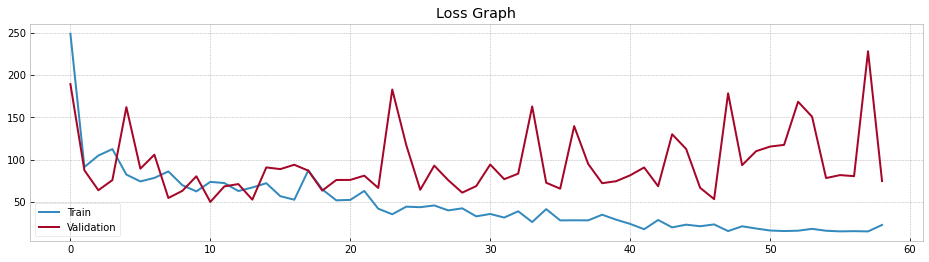

In [189]:
plot_losses(train_loss, val_loss)

In [175]:
best_model = mlp
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [192]:
#y_pred_train = mlp(torch.from_numpy(X_validation).float()).detach().numpy().T[0]

best_model.cpu()
mlp.cpu()
y_pred_1 = best_model(torch.from_numpy(X_validation).float()).detach().numpy().T[0]
print(y_pred_1)
print(y_validation)
compute_mse(y_pred_1, y_validation)
#wtf ?

[ 23.731997 171.36153   22.056097 ...  14.183601  12.009199  80.48586 ]
[ 3. 14.  2. ...  1.  1.  1.]
MSE = 6744.982241461019


In [97]:
#TO DO:

#- split X_train, y_train into train and test, so we can evaluate the MSE

# idea of features to add: (no learning)
# - number of papers
# - average of  number of papers of an author's co-author (will need the graph for this)

# add graph features: (no learning)
# see -> https://arxiv.org/ftp/arxiv/papers/1911/1911.08795.pdf

#run and save node embeddings with different methods (Node2Vec, Deepwalk..) using karateclub libary 
#try to play with the paramters
#record execution times

#- look for new features/methods from texts. 
#- different ways of combining word embeddings ?
#- train word embeddings on our dataset ?

# - do a pipeline and test every possible combination of features
# - (as done there https://github.com/vanessachahwan/ALTEGRAD-Challenge/blob/main/Report-BMV.pdf section 6)

# - compare different regression models
# - fine tune parameters for regression model 
